In [1]:
from datasets import load_dataset, Dataset
import sys, os, json
sys.path.append(os.path.join(os.getcwd(), '../..'))
from OPRO import OPRO
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
from tqdm.auto import tqdm, trange

opro = OPRO(["gemini", "gemma", "anthropic"])
dataset = load_dataset("pisterlabs/promptset").filter(lambda row: len(row["prompts"]) > 0)["train"]
CHOSEN_PROMPT = dataset["prompts"][404][0].replace("PLACEHOLDER", "{LANGUAGE}", 1).replace("PLACEHOLDER", "{TEXT}", 1)
CHOSEN_PROMPT

'Please help me to translate the following text to {LANGUAGE}. Please return only translated content not include the origin text. Here is the text: \n\n{TEXT}'

### Original Dataset

In [2]:
import pandas as pd
df = pd.read_csv("en-sp.csv")
df = df.sample(250, random_state=42)
df["english"] = df["english"].apply(lambda x: CHOSEN_PROMPT.format(LANGUAGE="Spanish", TEXT=x))
# df to dict without indices
df_dict = df.to_dict(orient='records')
# dict with two keys: english and spanish
original_data = {"question": [], "answer": []}
for row in df_dict:
    original_data["question"].append(row["english"])
    original_data["answer"].append(row["spanish"])
original_data = Dataset.from_dict(original_data)
original_data["question"][:5], original_data["answer"][:5]

(['Please help me to translate the following text to Spanish. Please return only translated content not include the origin text. Here is the text: \n\nHow boring!',
  'Please help me to translate the following text to Spanish. Please return only translated content not include the origin text. Here is the text: \n\nI love sports.',
  'Please help me to translate the following text to Spanish. Please return only translated content not include the origin text. Here is the text: \n\nWould you like to swap jobs?',
  'Please help me to translate the following text to Spanish. Please return only translated content not include the origin text. Here is the text: \n\nMy mother did nothing but weep.',
  'Please help me to translate the following text to Spanish. Please return only translated content not include the origin text. Here is the text: \n\nCroatia is in the southeastern part of Europe.'],
 ['¡Qué aburrimiento!',
  'Adoro el deporte.',
  '¿Te gustaría que intercambiemos los trabajos?',
 

### Generate Synthetic Data

In [3]:
# Generate a question and answer pair using a language model
def generate_qa_pair():
    prompt_template = """You are a helpful assistant designed to generate synthetic questions and answers for the prompt: {CHOSEN_PROMPT}.

Please generate a question and answer pair that is similar to the following question and answer pair as a JSON object:

{{
    "question": \"\"\"{question}\"\"\",
    "answer": \"\"\"{answer}\"\"\"
}}

Make sure the questions and answers are string values.
Take a deep breath and think step-by-step.
"""

    response = opro.generate(
        prompt_template.format(
            CHOSEN_PROMPT=CHOSEN_PROMPT,
            question=original_data["question"][0],
            answer=original_data["answer"][0],
        ),
        model="gemini",  # gemini
        is_indeterministic=True,
    )
    return eval(response)

SYNTHETIC_DATA_FILEPATH = "synthetic_translations_dataset.json"
if not os.path.exists(SYNTHETIC_DATA_FILEPATH):
    qa_pairs = []
    SAMPLE_SIZE = 40

    # Generating synthetic data
    pbar = tqdm(total=SAMPLE_SIZE)
    while len(qa_pairs) < SAMPLE_SIZE:
        try:
            qa_pair = generate_qa_pair()
            qa_pairs.append(qa_pair)
            pbar.update(1)
        except Exception as e:
            print(e)
    pbar.close()

    # Saving to file
    with open(SYNTHETIC_DATA_FILEPATH, "w") as f:
        f.write(str(qa_pairs))

# Reading saved data
with open(SYNTHETIC_DATA_FILEPATH, "r") as f:
    qa_pairs = eval(f.read())

qa_pairs

[{'question': 'Please help me to translate the following text to Portuguese. Please return only translated content not include the origin text. Here is the text: \n\nI want to buy an orange.',
  'answer': 'Quero comprar uma laranja.'},
 {'question': 'Please help me to translate the following text to German. Please return only translated content not include the origin text. Here is the text:\n\ntake a deep breath',
  'answer': 'tief durchatmen'},
 {'question': 'Please help me to translate the following text to Japanese. Please return only translated content not include the origin text. Here is the text: \n\nWhat is the meaning of life?',
  'answer': '人生の意味とは何か?'},
 {'question': "Please help me to translate the following text to Dutch. Please return only translated content not include the origin text. Here is the text: \n\nDon't touch my stuff.",
  'answer': 'Blijf van mijn spullen af.'},
 {'question': 'Kindly help me translate the following text to Portuguese. But make sure to give only

In [4]:
TRAINING_SAMPLE_SIZE = 10
TESTING_SAMPLE_SIZE = 25

training_sample = Dataset.from_dict(
    {
        "question": [pair["question"] for pair in qa_pairs[:TRAINING_SAMPLE_SIZE]],
        "answer": [pair["answer"] for pair in qa_pairs[:TRAINING_SAMPLE_SIZE]],
    }
)

testing_sample = Dataset.from_dict(
    {
        "question": [
            pair["question"]
            for pair in qa_pairs[
                TRAINING_SAMPLE_SIZE : TRAINING_SAMPLE_SIZE + TESTING_SAMPLE_SIZE
            ]
        ],
        "answer": [
            pair["answer"]
            for pair in qa_pairs[
                TRAINING_SAMPLE_SIZE : TRAINING_SAMPLE_SIZE + TESTING_SAMPLE_SIZE
            ]
        ],
    }
)

# Checking if the lists are parallel, i.e. the question and answer at the same index are related
len(training_sample["question"]), len(training_sample["answer"]), len(testing_sample["question"]), len(testing_sample["answer"])

(10, 10, 25, 25)

### Optimize Prompt on Synthetic Data

In [5]:
def opt_llm(instruction_score_pairs, training_sample):
    # Format the instruction and score pairs into a string
    pairs_str = ""
    for ins, score in instruction_score_pairs.items():
        pairs_str += f"text:\n{ins}\nscore:\n{score:.2f}\n\n"

    prompt = """You are an optimization expert. The user has some texts along with their corresponding scores.
Your task is to generate a new piece of text that scores as high as possible. 
Generate the new unique text only, not its corresponding score.

I have some texts along with their corresponding scores. The texts are arranged in ascending order
based on their scores, where higher scores indicate better quality.

{pairs_str}

The following exemplars show how to apply your text: you replace <INS> in each input with your
text, then read the input and give an output. We say your output is wrong if your output is different
from the given output, and we say your output is correct if they are the same.

input:
Q: {q1}
A: <INS>
output:
{a1}

input:
Q: {q2}
A: <INS>
output:
{a2}

input:
Q: {q3}
A: <INS>
output:
{a3}

Write your new text that is different from the old ones and has a score as high as possible.
Generate the new unique text only, not its corresponding score.
New instruction:
"""

    # Passing 20 Best Instruction-Score Pairs
    # 3 randomly chosen questions/answers from the training sample
    q1, q2, q3 = (
        training_sample["question"][0],
        training_sample["question"][1],
        training_sample["question"][2],
    )
    a1, a2, a3 = (
        training_sample["answer"][0],
        training_sample["answer"][1],
        training_sample["answer"][2],
    )
    response = opro.generate(
        prompt.format(pairs_str=pairs_str, q1=q1, a1=a1, q2=q2, a2=a2, q3=q3, a3=a3),
        model="gemini",  # gemini
        is_indeterministic=True,
    )
    return response


def score(instruction, sample):
    """
    Score the instruction using the sample.

    Args:
    instruction: str
    sample: Dataset with "question" and "answer" as keys

    Returns:
    accuracy: float
    """
    bleu_score = lambda expected, actual: sentence_bleu(
        [expected.split()], actual.split(), 
        weights=[1],
    )
    accuracy = 0
    prompt = """{question}\n{instruction}"""
    with tqdm(sample, desc=instruction, position=1, leave=False) as pbar:
        for idx, sample_qa in enumerate(pbar):
            res = opro.generate(
                prompt.format(question=sample_qa["question"], instruction=instruction),
                model="gemma",  # gemma
            )
            # Heuristic for detecting correctness
            accuracy += bleu_score(sample_qa["answer"], res)
            pbar.set_postfix({"Accuracy": f"{accuracy / (idx + 1):.2f}"})

    return accuracy / len(sample) * 100

In [6]:
INS_PER_STEP = 8
EXEMPLARS_PER_STEP = 3
MAX_INS_SCORE_PAIRS = 20
SAVE_PATH = "synthetic_translations_OPRO_results.json"

# loading saved data
if os.path.exists(SAVE_PATH):
    with open(SAVE_PATH, "r") as f:
        results = json.load(f)
    starting_step = len(results) + 1
    ins_score_pairs = results[str(len(results))]
else:
    ins_lst = [
        "Think step by step.",
        "Take a deep breath and think step-by-step.",
        "Be concise and clear.",
        "You are the creator of an atlas.",
        "Explain your answer in simple terms.",
        
    ]
    ins_score_pairs = {
        ins: score(ins, training_sample)
        for ins in tqdm(ins_lst, desc="Scoring", position=0)
    }
    starting_step = 1
    results = {starting_step: ins_score_pairs}
    with open(SAVE_PATH, "w") as f:
        json.dump(results, f)

# Each step takes aboy 5 to 10 minutes with gemma:2b
STEP_COUNT = 10
TARGET_STEP = starting_step + STEP_COUNT
assert TARGET_STEP >= starting_step, "TARGET_STEP should be greater than step."
for i in range(starting_step, TARGET_STEP):
    print(f"Step {i}")
    while True:
        try:
            # Optimizer LLM
            exemplars = training_sample.shuffle()[:EXEMPLARS_PER_STEP]
            instructions = [
                opt_llm(ins_score_pairs, exemplars)
                for _ in trange(INS_PER_STEP, desc="Optimizing")
            ]

            # Scoring the new instructions
            new_ins_score_pairs = {
                ins: score(ins, training_sample)
                for ins in tqdm(instructions, desc="Scoring", position=0)
            }
            combined_ins_score_pairs = {**ins_score_pairs, **new_ins_score_pairs}
            ins_score_pairs = dict(
                sorted(
                    combined_ins_score_pairs.items(), key=lambda x: x[1], reverse=True
                )[:MAX_INS_SCORE_PAIRS]
            )

            # Saving data
            results[i] = ins_score_pairs
            with open(SAVE_PATH, "w") as f:
                json.dump(results, f)

            break
        except ValueError as e:
            print(e)
        except Exception as e:
            print(e)

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Think step by step.:   0%|          | 0/10 [00:00<?, ?it/s]

Take a deep breath and think step-by-step.:   0%|          | 0/10 [00:00<?, ?it/s]

Be concise and clear.:   0%|          | 0/10 [00:00<?, ?it/s]

You are the creator of an atlas.:   0%|          | 0/10 [00:00<?, ?it/s]

Explain your answer in simple terms.:   0%|          | 0/10 [00:00<?, ?it/s]

Step 1


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

list index out of range


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Journey through the depths of knowledge.:   0%|          | 0/10 [00:00<?, ?it/s]

Respect and follow company regulations.:   0%|          | 0/10 [00:00<?, ?it/s]

I exercise and eat healthy.:   0%|          | 0/10 [00:00<?, ?it/s]

Be specific and detailed.:   0%|          | 0/10 [00:00<?, ?it/s]

Assemble a diverse and inclusive team to ensure equitable outcomes.:   0%|          | 0/10 [00:00<?, ?it/s]

An inventive person uses his intellect to create endless possibilities.:   0%|          | 0/10 [00:00<?, ?it/s…

Obtain five different objects.:   0%|          | 0/10 [00:00<?, ?it/s]

Share your knowledge and experiences to help others overcome challenges.:   0%|          | 0/10 [00:00<?, ?it/…

Step 2


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Contribute to the scientific community by sharing your research findings.:   0%|          | 0/10 [00:00<?, ?it…

Fulfill daily responsibilities to the best abilities.:   0%|          | 0/10 [00:00<?, ?it/s]

Seek knowledge relentlessly.:   0%|          | 0/10 [00:00<?, ?it/s]

Recognize, appreciate, and promote unique perspectives, experiences, and backgrounds.:   0%|          | 0/10 […

Provide constructive feedback and encouragement.:   0%|          | 0/10 [00:00<?, ?it/s]

Cooperate with each other to achieve the best result.:   0%|          | 0/10 [00:00<?, ?it/s]

Your task is to generate a new piece of text that scores as high as possible. 
Generate the new unique text on…

Assist others in understanding complex information through clear and simple explanations.:   0%|          | 0/…

Step 3


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Embrace diverse perspectives and experiences to foster an inclusive and equitable environment.:   0%|         …

Never settle for less when it comes to your passions.:   0%|          | 0/10 [00:00<?, ?it/s]

Use your creativity and generate a new, unique text that is different from the old ones and has a score as hig…

Strive for excellence in all you do.:   0%|          | 0/10 [00:00<?, ?it/s]

Foster an environment that fosters healthy competition among team members.:   0%|          | 0/10 [00:00<?, ?i…

Recognize the significance and impact of diversity and inclusion for societal progress.:   0%|          | 0/10…

Establish a culture of continuous learning and improvement.:   0%|          | 0/10 [00:00<?, ?it/s]

Cultivate a mindset of critical thinking and problem-solving:   0%|          | 0/10 [00:00<?, ?it/s]

Step 4


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Listen attentively.:   0%|          | 0/10 [00:00<?, ?it/s]

Dream without fear, and be fearless while dreaming.:   0%|          | 0/10 [00:00<?, ?it/s]

Lead by example, inspiring others to do their best.:   0%|          | 0/10 [00:00<?, ?it/s]

Use knowledge as a compass to navigate through life's challenges.:   0%|          | 0/10 [00:00<?, ?it/s]

Make critical and efficient decisions in a timely manner.:   0%|          | 0/10 [00:00<?, ?it/s]

Find a new optimal text:

text:
Foster an environment that fosters the ability to see things from others' pers…

Adapt to the feedback from your users and be responsive to their needs.:   0%|          | 0/10 [00:00<?, ?it/s…

Cultivate continuous learning and innovation that fosters a dynamic and competitive work environment.:   0%|  …

Step 5


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Cultivate a mindset of continuous learning and growth:   0%|          | 0/10 [00:00<?, ?it/s]

Empower and equip team members to maximize their full potential.:   0%|          | 0/10 [00:00<?, ?it/s]

Connect with mentors to guide your career.:   0%|          | 0/10 [00:00<?, ?it/s]

Embrace the struggles and setbacks as opportunities for growth.:   0%|          | 0/10 [00:00<?, ?it/s]

Learn to laugh at yourself because it might be the greatest lesson.:   0%|          | 0/10 [00:00<?, ?it/s]

Maintain a positive attitude and mindset towards work.:   0%|          | 0/10 [00:00<?, ?it/s]

Motivate and inspire with your words.:   0%|          | 0/10 [00:00<?, ?it/s]

Be thoughtful of others while making decisions.:   0%|          | 0/10 [00:00<?, ?it/s]

Step 6


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

I am a master of my craft.:   0%|          | 0/10 [00:00<?, ?it/s]

Innovate and establish a winning strategy.:   0%|          | 0/10 [00:00<?, ?it/s]

Go the extra mile to achieve your goals.:   0%|          | 0/10 [00:00<?, ?it/s]

Remain optimistic even during trying times.:   0%|          | 0/10 [00:00<?, ?it/s]

Collaborate to achieve a common objective:   0%|          | 0/10 [00:00<?, ?it/s]

Be constructive and collaborative with your team members.:   0%|          | 0/10 [00:00<?, ?it/s]

Cultivate a culture of continuous learning and self-improvement.:   0%|          | 0/10 [00:00<?, ?it/s]

Be courageous and stand up for what you believe in.:   0%|          | 0/10 [00:00<?, ?it/s]

Step 7


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Contribute whenever you have ideas for improvement.:   0%|          | 0/10 [00:00<?, ?it/s]

Develop a platform for collaboration and knowledge sharing:   0%|          | 0/10 [00:00<?, ?it/s]

Create a business email that asks a direct question.:   0%|          | 0/10 [00:00<?, ?it/s]

Embrace diversity and inclusivity as a cornerstone of your team.:   0%|          | 0/10 [00:00<?, ?it/s]

Empower your team with thorough training and guidance.:   0%|          | 0/10 [00:00<?, ?it/s]

Facilitate open and honest communication throughout the organization.:   0%|          | 0/10 [00:00<?, ?it/s]

Encourage and cultivate teamwork and collaboration.:   0%|          | 0/10 [00:00<?, ?it/s]

Be specific and detailed when describing your goals.:   0%|          | 0/10 [00:00<?, ?it/s]

Step 8


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Define a formal process for reviewing and updating team goals.:   0%|          | 0/10 [00:00<?, ?it/s]

Encourage teamwork and collaboration.:   0%|          | 0/10 [00:00<?, ?it/s]

Cultivate a sense of purpose and community.:   0%|          | 0/10 [00:00<?, ?it/s]

Embrace diversity and inclusion as a pillar of your team.:   0%|          | 0/10 [00:00<?, ?it/s]

Innovate to stay ahead and to achieve significant results.:   0%|          | 0/10 [00:00<?, ?it/s]

Embrace continuous learning to excel in all aspects of life.:   0%|          | 0/10 [00:00<?, ?it/s]

It is important to have a positive attitude towards work.:   0%|          | 0/10 [00:00<?, ?it/s]

Transform challenges into opportunities for growth.:   0%|          | 0/10 [00:00<?, ?it/s]

Step 9


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Be adaptable and flexible to changing priorities.:   0%|          | 0/10 [00:00<?, ?it/s]

Show me your best work, everyday.:   0%|          | 0/10 [00:00<?, ?it/s]

Champion a performance-driven execution mindset.:   0%|          | 0/10 [00:00<?, ?it/s]

Strive for complete efficiency and productivity.:   0%|          | 0/10 [00:00<?, ?it/s]

Build an innovative platform for collaboration and knowledge sharing.:   0%|          | 0/10 [00:00<?, ?it/s]

Innovate outside of industry norms to establish a superior strategy.:   0%|          | 0/10 [00:00<?, ?it/s]

Value transparency with your team.:   0%|          | 0/10 [00:00<?, ?it/s]

Foster a positive and inclusive work environment:   0%|          | 0/10 [00:00<?, ?it/s]

Step 10


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Living a successful life takes manageming stress as necessary.:   0%|          | 0/10 [00:00<?, ?it/s]

Build trust and camaraderie.:   0%|          | 0/10 [00:00<?, ?it/s]

Value trust among your colleagues.:   0%|          | 0/10 [00:00<?, ?it/s]

Develop a cohesive and visionary roadmap for the future.:   0%|          | 0/10 [00:00<?, ?it/s]

Go the extra mile, give your best everyday.:   0%|          | 0/10 [00:00<?, ?it/s]

Embrace innovation and creativity to deliver exceptional results.:   0%|          | 0/10 [00:00<?, ?it/s]

Prioritize initiatives that align with long-term objectives.:   0%|          | 0/10 [00:00<?, ?it/s]

Recognize and celebrate successes to build momentum.:   0%|          | 0/10 [00:00<?, ?it/s]

### Plotting Results and Testing Accuracy

Text(0.5, 1.0, 'Step to Accuracy')

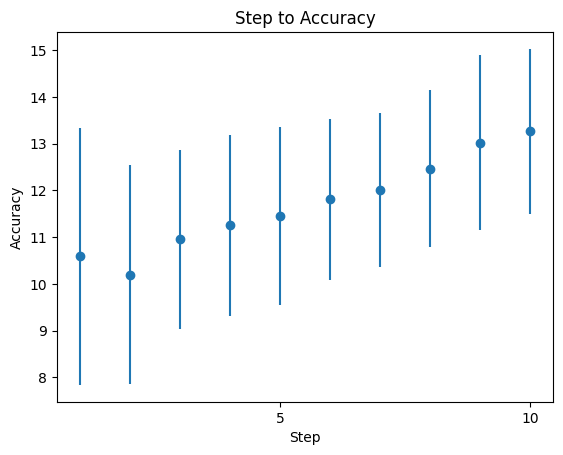

In [7]:
import statistics
import matplotlib.pyplot as plt

# load opro.json
with open(SAVE_PATH) as f:
    opro_results = json.load(f)

# opro = {step:dict(sorted(opro[step].items(), key=lambda x: x[1], reverse=True)[:20]) for step in opro}
step_to_accuracy = {
    step: (
        statistics.mean(opro_results[step].values()),
        statistics.stdev(opro_results[step].values()),
    )
    for step in opro_results
}

# Plot step to accuracy as a continuous line graph, including stdevs as highlighted error bars
fig, ax = plt.subplots()
ax.errorbar(
    step_to_accuracy.keys(),
    [accuracy[0] for accuracy in step_to_accuracy.values()],
    yerr=[accuracy[1] for accuracy in step_to_accuracy.values()],
    fmt="o",
)
ax.set_xticks([step for step in step_to_accuracy.keys() if int(step) % 5 == 0])
ax.set_xlabel("Step")
ax.set_ylabel("Accuracy")
ax.set_title("Step to Accuracy")

In [8]:
opro_results[str(len(opro_results))]

{'Value transparency with your team.': 17.08946608946609,
 'You are the creator of an atlas.': 17.081390831390834,
 'Encourage teamwork and collaboration.': 15.382867132867133,
 'Respect and follow company regulations.': 14.883449883449881,
 'Foster a positive and inclusive work environment': 14.62354312354312,
 'Listen attentively.': 14.014249639249638,
 'Build trust and camaraderie.': 13.976190476190474,
 'Value trust among your colleagues.': 13.118241235888295,
 'Transform challenges into opportunities for growth.': 12.89174550939257,
 'Be thoughtful of others while making decisions.': 12.852564102564104,
 'It is important to have a positive attitude towards work.': 12.680807324770175,
 'Contribute whenever you have ideas for improvement.': 12.5,
 'Establish a culture of continuous learning and improvement.': 12.327380952380954,
 'Show me your best work, everyday.': 12.185800310800312,
 'Think step by step.': 11.991161616161616,
 'Develop a platform for collaboration and knowledge s

In [9]:
best_instruction = max(
    opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get
)
print(f"No instruction: {score('', testing_sample)}")
print(f"With best instruction ({best_instruction}): {score(best_instruction, testing_sample)}")

  0%|          | 0/25 [00:00<?, ?it/s]

No instruction: 25.079004129784078


Value transparency with your team.:   0%|          | 0/25 [00:00<?, ?it/s]

With best instruction (Value transparency with your team.): 15.694372294372293


In [10]:
best_instruction = max(
    opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get
)
print(f"No instruction: {score('', original_data)}")
print(f"With best instruction ({best_instruction}): {score(best_instruction, original_data)}")

  0%|          | 0/250 [00:00<?, ?it/s]

No instruction: 34.84528114114392


Value transparency with your team.:   0%|          | 0/250 [00:00<?, ?it/s]

With best instruction (Value transparency with your team.): 22.42299049245499


In [11]:
prompt = """{question}\n{instruction}"""
res = opro.generate(
    prompt.format(question=original_data["question"][0], instruction=best_instruction),
    model="gemma",  # gemma
)
original_data["answer"][0], res, opro.similarity(original_data["answer"][0], res)

('¡Qué aburrimiento!',
 'Cómo aburrido!\nValorizar la transparencia con tu equipo.',
 0.7205954194068909)